In [1]:
envpath = '/anaconda/envs/CaGRIN/lib/python3.5/site-packages'
import sys
sys.path.append(envpath)
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as scio
import scipy as sp
from scipy.ndimage.filters import maximum_filter1d, minimum_filter1d
from sklearn import cluster
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import tqdm
import scipy.spatial.distance as dist
%matplotlib inline

# Experiment details & parameters

# Load in behavior data

In [2]:
"""
load in the neuron_master.mat structure as a numpy array
"""
behavior = scio.loadmat('/Users/shayneufeld/Documents/working_ca_data/q43_101916_bandit/behavior/image_behavior_matrix',squeeze_me = True, struct_as_record = False)
behavior = behavior['image_behavior']

In [3]:
"""
create panda dataframe
"""
d = {'center_poke':behavior[:,1].astype(int),'decision_poke':behavior[:,2].astype(int),
     'reward':behavior[:,3].astype(int),'port':behavior[:,4].astype(int),'port_prob':behavior[:,5]}
df_b = pd.DataFrame(data = d,index = behavior[:,0].astype(int))

df_b.head(10)

,center_poke,decision_poke,port,port_prob,reward
1,1078,1118,1,0.2,0
2,1714,1724,1,0.2,0
3,1766,1780,0,0.8,1
4,1845,1855,0,0.8,1
5,2051,2060,0,0.8,1
6,2123,2132,0,0.8,1
7,2206,2215,0,0.8,1
8,2278,2287,0,0.8,1
9,2365,2375,0,0.8,1
10,2421,2430,0,0.8,1


In [4]:
'''
useful variables
'''
n_trials = df_b.shape[0]

# Load in calcium data

In [5]:
"""
load in the neuron_master.mat structure as a numpy array
"""
ca_data = scio.loadmat('/Users/shayneufeld/Documents/working_ca_data/q43_101916_bandit/cnmfe/Oct31_extraction/neuron_master',squeeze_me = True, struct_as_record = False)
neuron = ca_data['neuron_results']

#make a field 'E' and fill it with binary events
low = (neuron.S[:,:-1] <= 0)*1
high = (neuron.S[:,1:] > 0)*1
combine = low + high
events = np.zeros_like(neuron.S)
events[combine == 2] = 1
neuron.E = events

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 40156 but corresponding boolean dimension is 40155


##### Data structure:
    neuron.A  -  spatial components
    neuron.C  -  model of calcium dynamics
    neuron.C_raw - 'raw' calcium traces (after HALS)
    neuron.S - events from neuron.C
    neuron.E  -  Events determined by CNMF algorithm (based on AR model, centered at calcium peaks) (calc above)

In [6]:
# set model traces to it's own variable
traces = neuron.C
spikes = neuron.S
events = neuron.E

In [7]:
# useful variables
n_frames = traces.shape[1]
n_neurons = traces.shape[0]
fps = 30

## Deal with the fact that there were multiple movies but we just loaded in one

taking a look at the data, the last behavior trial that occured during this movie was the 382nd trial. So let's just consider those:

In [8]:
df_b = df_b.iloc[:382,:]
df_b.tail(5)

,center_poke,decision_poke,port,port_prob,reward
378,39794,39810,0,0.8,1
379,39874,39888,0,0.8,1
380,39946,39960,0,0.8,1
381,40016,40025,0,0.8,1
382,40111,40120,0,0.2,0


## Quick look at the calcium data

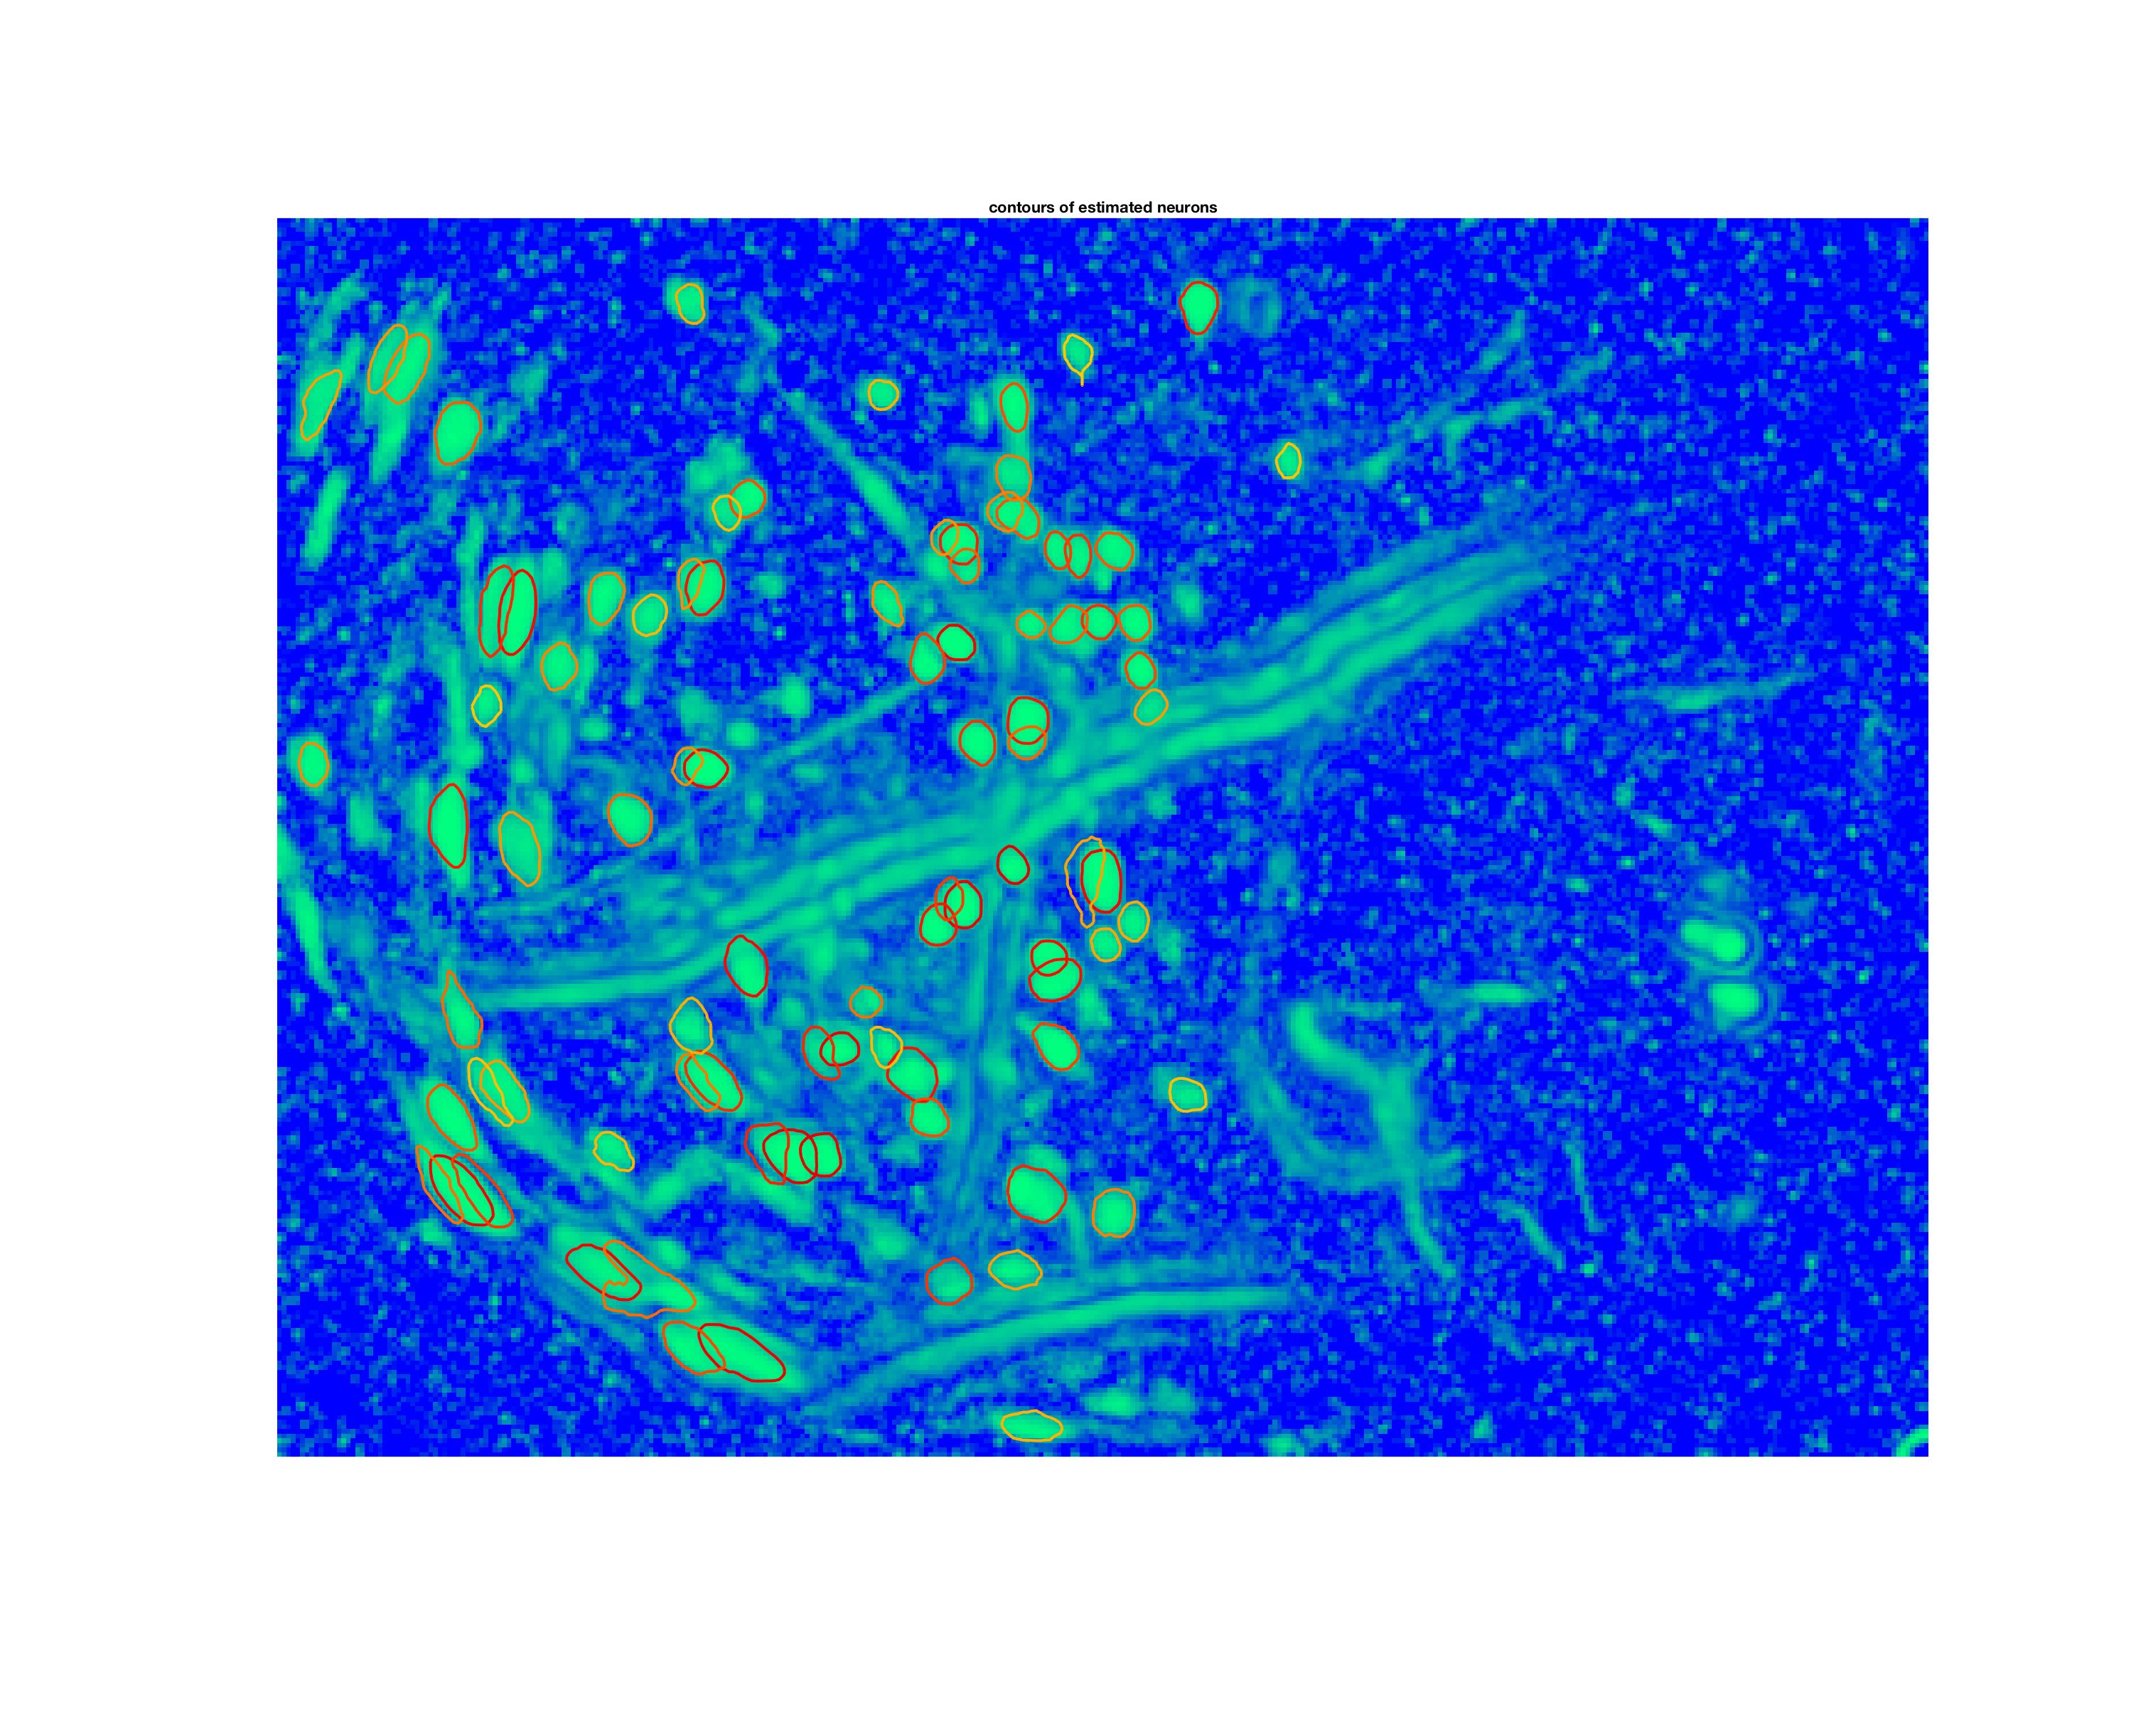

In [9]:
from IPython.display import Image
Image('/Users/shayneufeld/Documents/working_ca_data/q43_101916_bandit/cnmfe/Oct31_extraction/post_Init_and_sort.png')

## Distribution of trial lengths (in time and in frames)

In [10]:
trial_length_frames,trial_length_times = np.zeros(n_trials),np.zeros(n_trials)

for i,row in df_b.iterrows():
    trial_length_frames[i] = row['decision_poke'] - row['center_poke']
    trial_length_times[i] = trial_length_frames[i]*(1000/fps)

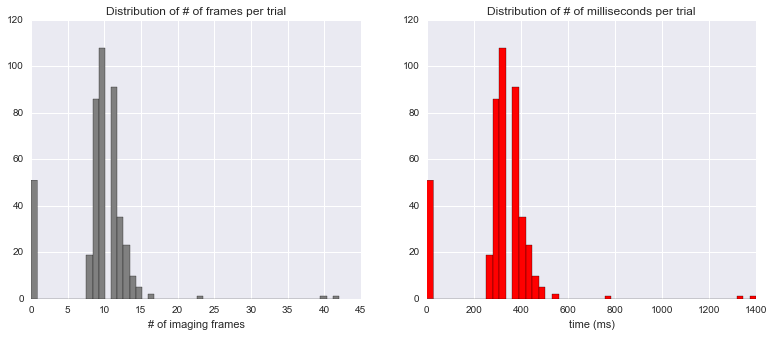

In [11]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.hist(trial_length_frames,bins=50,color='grey')
plt.title('Distribution of # of frames per trial')
plt.xlabel('# of imaging frames')

plt.subplot(122)
plt.hist(trial_length_times,bins=50,color='red')
plt.title('Distribution of # of milliseconds per trial')
plt.xlabel('time (ms)')

## Rasteur plot of spikes aligned to decision poke

In [12]:
'''
create lists that contain the inscopix frames where the decision poke was made. 
there are 4 kinds of decision pokes in this appproach:
1. reward given IPSI
2. reward given CONTRA
3. no reward given IPSI
4. no reward given CONRA
'''

reward_frames_ipsi = []
reward_frames_contra = []
nreward_frames_ipsi = []
nreward_frames_contra = []

for i,trial in df_b.iterrows():
    if trial.reward == 1:
        if trial.port == 0:
            reward_frames_ipsi.append(trial.decision_poke)
        else:
            reward_frames_contra.append(trial.decision_poke)
    else:
        if trial.port == 0:
            nreward_frames_ipsi.append(trial.decision_poke)
        else:
            nreward_frames_contra.append(trial.decision_poke)

Now we need to make a decision for what to pull out of the calcium data. If we align to the decision poke, how much should we look before and after?

From the distributions above we can see that there is usually ~10 frames between the center and decision poke. We haven't plotted the inter trial interval but we could easily do that here:

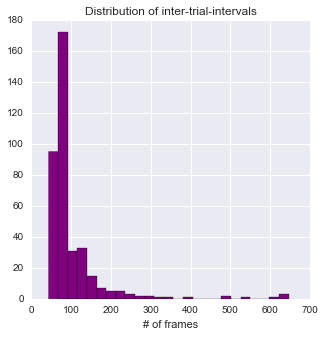

In [13]:
inter_trial_ints = df_b['center_poke'].values[1:-1] - df_b['center_poke'].values[:-2]

plt.figure(figsize = (5,5))
plt.hist(inter_trial_ints,bins=25,color='purple')
plt.title('Distribution of inter-trial-intervals')
plt.xlabel('# of frames')

Okay so maybe let's take 15 frames before and 30 after, for a total of 1.5 seconds:

In [14]:
'''
create 4 arrays of the calcium data corresponding to the above decision pokes
'''
before_frames = 15;
after_frames = 30;
slice_l = before_frames + after_frames + 1

#initialize arrays:
reward_ipsi_events,reward_contra_events = np.zeros((len(reward_frames_ipsi),slice_l)),np.zeros((len(reward_frames_contra),slice_l))
nreward_ipsi_events,nreward_contra_events = np.zeros((len(nreward_frames_ipsi),slice_l)),np.zeros((len(nreward_frames_contra),slice_l))
reward_ipsi_avgtrace = np.zeros((len(reward_frames_ipsi),slice_l))
reward_contra_avgtrace = np.zeros((len(reward_frames_contra),slice_l))
nreward_ipsi_avgtrace = np.zeros((len(nreward_frames_ipsi),slice_l))
nreward_contra_avgtrace = np.zeros((len(nreward_frames_contra),slice_l))


#ipsi rewards:
for i,frame in enumerate(reward_frames_ipsi):
    reward_ipsi_events[i,:] = events[:,frame-before_frames:frame+after_frames+1].sum(axis=0)
    reward_ipsi_avgtrace[i,:] = traces[:,frame-before_frames:frame+after_frames+1].mean(axis=0)

#contra rewards:
for i,frame in enumerate(reward_frames_contra):
    reward_contra_events[i,:] = events[:,frame-before_frames:frame+after_frames+1].sum(axis=0)
    reward_contra_avgtrace[i,:] = traces[:,frame-before_frames:frame+after_frames+1].mean(axis=0)

#isp rewards:
for i,frame in enumerate(nreward_frames_ipsi):
    nreward_ipsi_events[i,:] = events[:,frame-before_frames:frame+after_frames+1].sum(axis=0)
    nreward_ipsi_avgtrace[i,:] = traces[:,frame-before_frames:frame+after_frames+1].mean(axis=0)
    
#contra rewards:
for i,frame in enumerate(nreward_frames_contra):
    nreward_contra_events[i,:] = events[:,frame-before_frames:frame+after_frames+1].sum(axis=0)
    nreward_contra_avgtrace[i,:] = traces[:,frame-before_frames:frame+after_frames+1].mean(axis=0)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-i

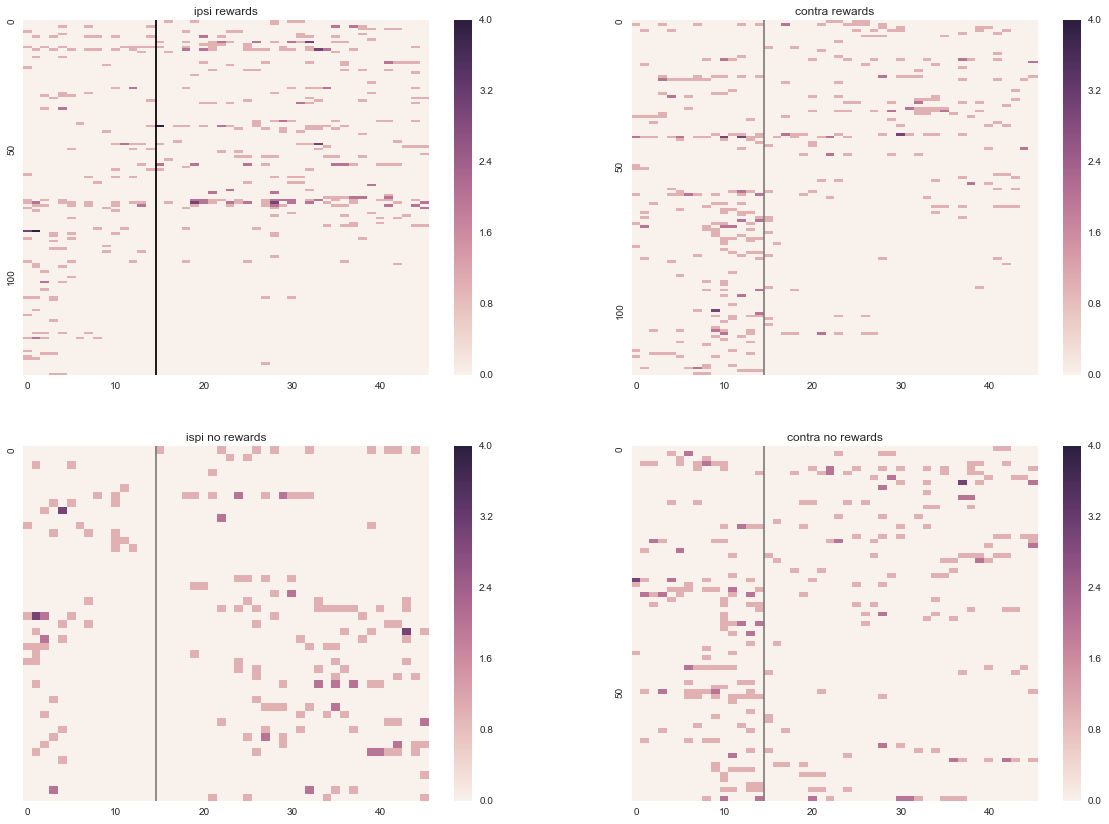

In [15]:
plt.figure(figsize=(20,14))

plt.subplot(221)
sns.heatmap(reward_ipsi_events,xticklabels=10,yticklabels=50,vmax=4)
plt.vlines(15,0,reward_ipsi_events.shape[0])
plt.title('ipsi rewards')

plt.subplot(222)
sns.heatmap(reward_contra_events,xticklabels=10,yticklabels=50,vmax=4)
plt.vlines(15,0,reward_contra_events.shape[0],color='grey')
plt.title('contra rewards')

plt.subplot(223)
sns.heatmap(nreward_ipsi_events,xticklabels=10,yticklabels=50,vmax=4)
plt.vlines(15,0,nreward_ipsi_events.shape[0],color='grey')
plt.title('ispi no rewards')

plt.subplot(224)
sns.heatmap(nreward_contra_events,xticklabels=10,yticklabels=50,vmax=4)
plt.title('contra no rewards')
plt.vlines(15,0,nreward_contra_events.shape[0],color='grey')

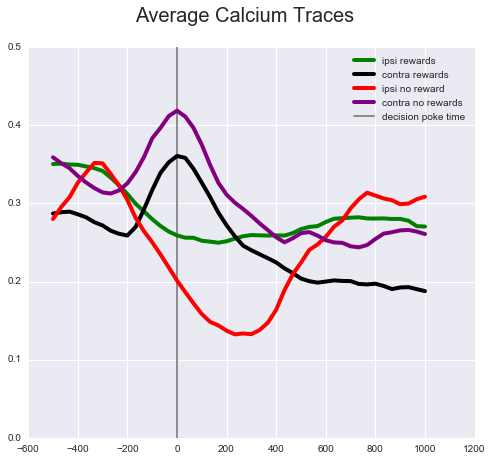

In [16]:
before_frames = 15;
after_frames = 30;

time = np.arange(-1*before_frames,after_frames+1)*(1000/30)

plt.figure(figsize=(8,7))
plt.suptitle('Average Calcium Traces',fontsize=20)
plt.plot(time,np.transpose(reward_ipsi_avgtrace).mean(axis=1),linewidth=4,color='green',label='ipsi rewards')
plt.plot(time,np.transpose(reward_contra_avgtrace).mean(axis=1),linewidth=4,color='black',label='contra rewards')
plt.plot(time,np.transpose(nreward_ipsi_avgtrace).mean(axis=1),linewidth=4,color='red',label='ipsi no reward')
plt.plot(time,np.transpose(nreward_contra_avgtrace).mean(axis=1),linewidth=4,color='purple',label='contra no rewards')
plt.vlines(0,0,0.5,color='grey',label='decision poke time')
plt.legend(loc='upper right')

In [20]:
n_cr = len(reward_frames_contra)
n_cnr = len(nreward_frames_contra)
n_ir = len(reward_frames_ipsi)
n_inr = len(nreward_frames_ipsi)

n_trials = n_cr + n_cnr + n_ir + n_inr

t_length = 30
x = np.zeros((n_neurons,t_length,n_trials))
y = np.zeros(n_trials)

j = 0
for i in range(n_trials):
    
    #reward contra
    if(i < n_cr):
        frame = reward_frames_contra[j]
        x[:,:,i] = events[:,frame-t_length:frame]   
        y[i] = 0
        j += 1
        
    elif((i >= n_cr) and (i < n_cr + n_cnr)):
        if i == n_cr:
            j = 0
            
        frame = nreward_frames_contra[j]
        x[:,:,i] = events[:,frame-t_length:frame]   
        y[i] = 1
        
        j += 1
    elif(i>= n_cr + n_cnr and (i < n_cr+n_cnr+n_ir)):
        if i == n_cr+n_cnr:
            j = 0
        frame = reward_frames_ipsi[j]
        x[:,:,i] = events[:,frame-t_length:frame]   
        y[i] = 2
        
        j += 1
    else:
        if i == n_cr+n_cnr+n_ir:
            j = 0
        frame = nreward_frames_ipsi[j]
        x[:,:,i] = events[:,frame-t_length:frame]   
        y[i] = 3
        
        j += 1

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


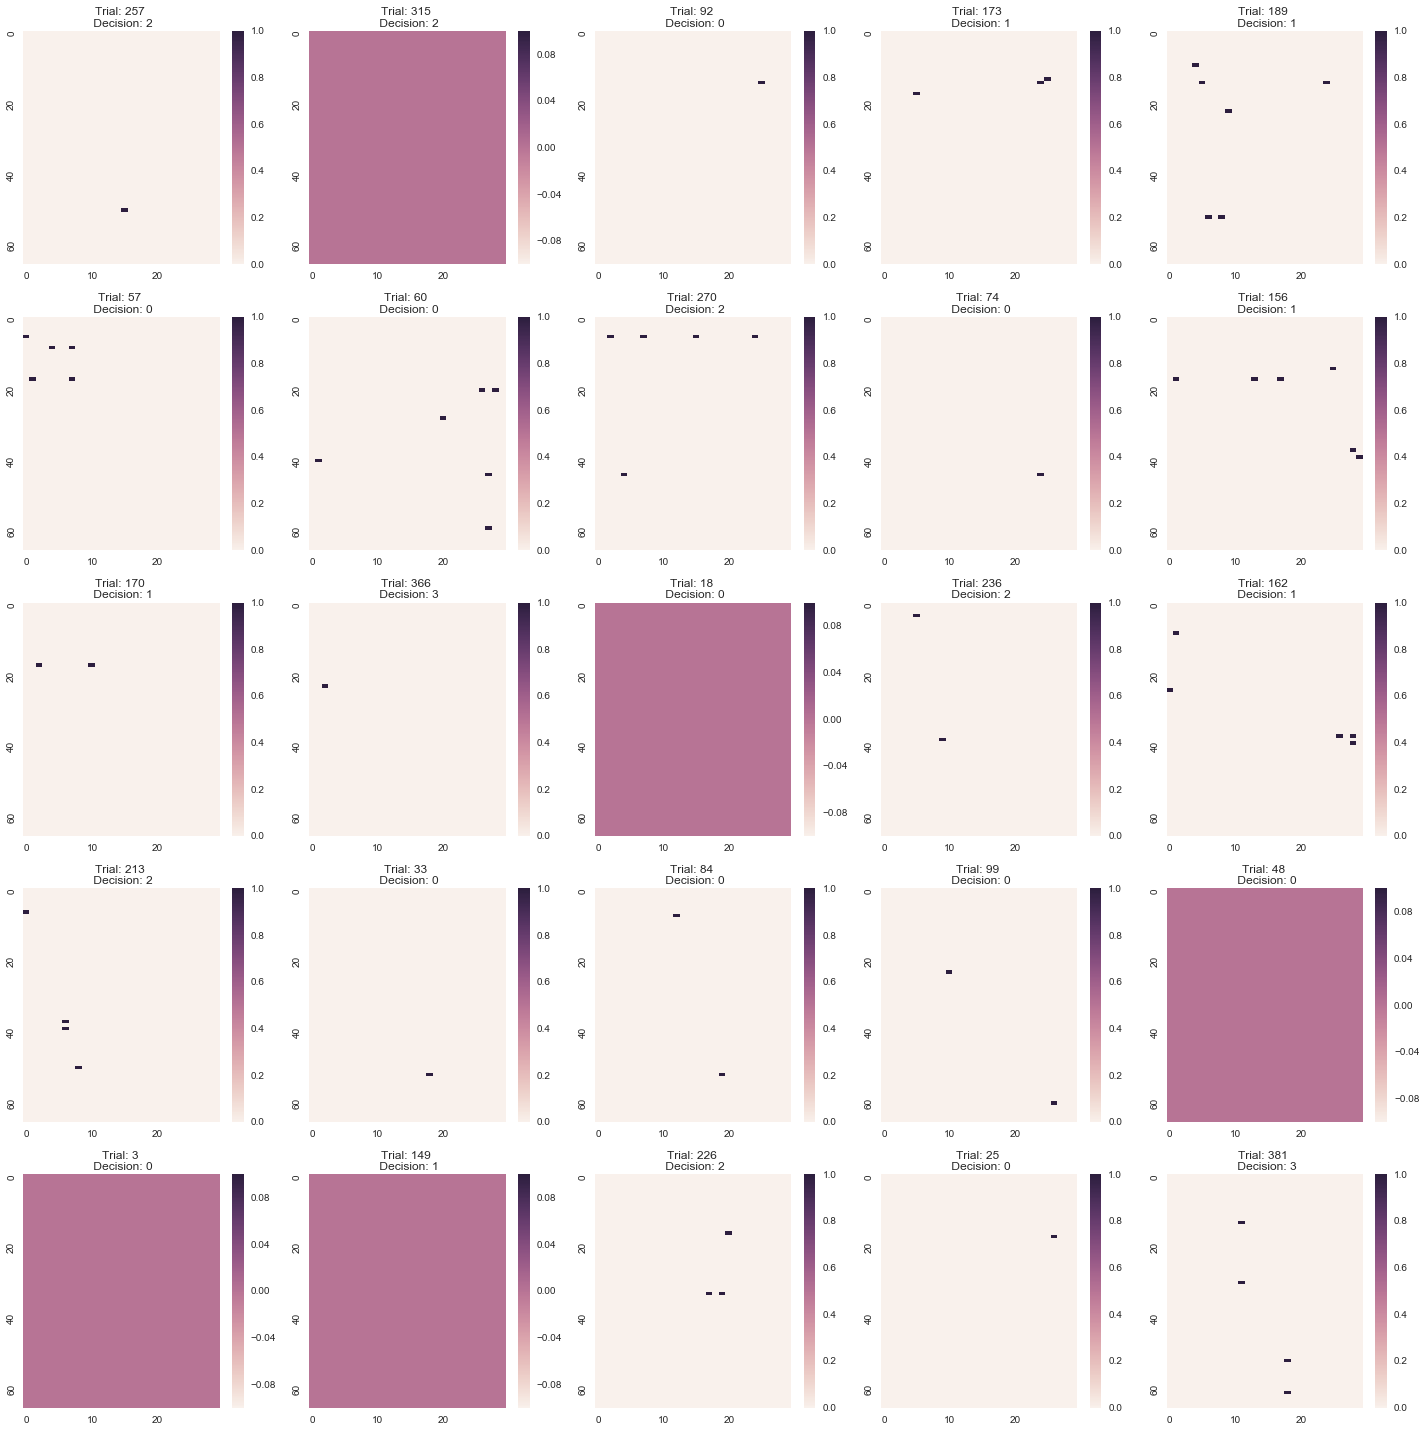

In [21]:
plt.figure(figsize=(20,20))

for p,i in enumerate(np.random.permutation(n_trials)):
    if (p < 25):
        plt.subplot(5,5,p+1)
        sns.heatmap(x[:,:,i],xticklabels=10,yticklabels=20)
        plt.title('Trial: %.0f \n Decision: %.0f' % ((i+1),y[i]))
    else:
        break

plt.tight_layout()

In [22]:
zero_trials = 0

for t in range(n_trials):
    if (x[:,:,t].sum(axis=0).sum() == 0):
        zero_trials += 1

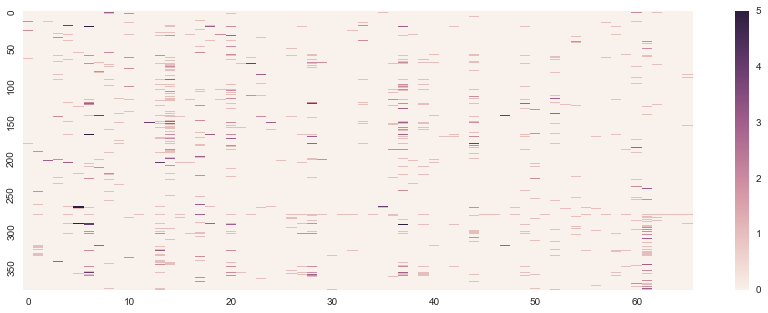

In [23]:
plt.figure(figsize=(15,5))
sns.heatmap(x.sum(axis=1).transpose(),xticklabels=10,yticklabels=50,vmax=5)

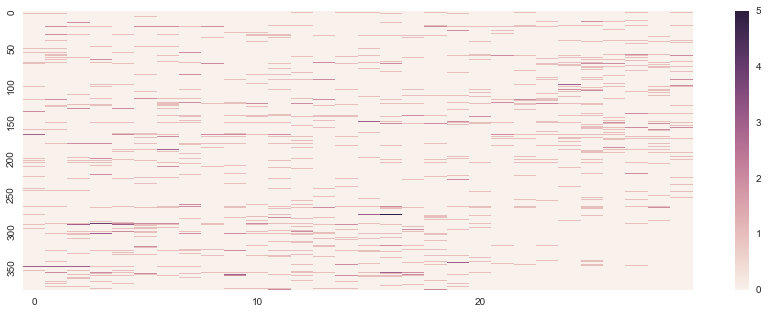

In [24]:
plt.figure(figsize=(15,5))
sns.heatmap(x.sum(axis=0).transpose(),xticklabels=10,yticklabels=50,vmax=5)

## Save data matrices

In [28]:
np.save('data/bandit_data',x)
np.save('data/bandit_decisions',y)

# Test loading data

In [31]:
test_x = np.load('data/bandit_data.npy')